Source https://lava-nc.org

Working with data from <code>Prepocessing/data/spikeTrains</code> should have folder for each experment setup (in terms of disctance of magnent in mm). Each folder should have a list of spike trains as csv files. Spike trains are recorded as events per 0.05 secs. The index file has the list of each spike train path and the class they are in. Classes are configureable via the preprocessing but should be somthing like this 

<table style="border:none;padding: 10px;margin: auto;">
    <tr style="border:none;padding: 10px;margin: auto;">
        <td style="border:none;padding: 10px;margin: auto;">
        9/5mm
        <table>
            <tr> <td>High</td> <td>>300</td> </tr>
            <tr> <td>Medium</td> <td>300-230</td> </tr>
            <tr> <td>Low</td> <td>&lt;230</td> </tr>
        </table>
        </td>
        <td style="border:none;padding: 10px;margin: auto;">
        3mm
        <table>
            <tr> <td>High</td> <td>>150</td> </tr>
            <tr> <td>Medium</td> <td>100-150</td> </tr>
            <tr> <td>Low</td> <td>&lt;100</td> </tr>
        </table>
        </td>
        <td style="border:none;padding: 10px;margin: auto;">
        2/1.5mm
        <table>
            <tr> <td>High</td> <td>>50</td> </tr>
            <tr> <td>Medium</td> <td>30-50</td> </tr>
            <tr> <td>Low</td> <td>&lt;30</td> </tr>
        </table>
        </td>
    </tr>
</table>

The plan is to use intel lava-nc 

In [186]:
%reset

----
#### DataLoader

This is our data loader. Should get an index file for an experment type (9mm,5mm etc). The index file should contain a path to each indiviual training experiment and the class it belongs to high, medium, or low.
Note that the class is represented as a int, the map is shown below

|class         | numerical value|
|--------------|----------------|
|<i>high</i>   |               2|
|<i>medium</i> |               1|
|<i>low</i>    |               0|

Example index file (Prepocessing/data/spikeTrains/1.5-SpikeTrains/index.csv)
<pre>
spikeTrain_1.csv,0
spikeTrain_2.csv,0
spikeTrain_3.csv,1
spikeTrain_4.csv,0
spikeTrain_5.csv,2
spikeTrain_6.csv,1
</pre>


Example spik train file (Prepocessing/data/spikeTrains/1.5-SpikeTrains/spikeTrain_1.csv)
<pre>
0
0
0
.
.
.
0
0
1
0
.
.
.
</pre>

In [187]:
import numpy as np
import pandas as pd
import os

class expermentDataloader:
    def __init__(
        self,
        index_file: str, 
        data_path: str,
    ):
        self.root_dir = data_path
        self.expermentSikeTrainsIndex = pd.read_csv(index_file) # self.landmarks_frame = pd.read_csv(csv_file)
        self.spikeTrains = [
            f"{os.path.join(self.expermentSikeTrainsIndex.iloc[i, 0])}" for i in range(len(self.expermentSikeTrainsIndex)) 
        ]
        self.expermentClasses = self.expermentSikeTrainsIndex.iloc[:, 1]

    def __getitem__(self, index):
        CSVlines = pd.read_csv(os.path.join(self.root_dir,self.spikeTrains[index])).to_numpy()
        eventClass = self.expermentClasses[index]
        return np.array(list(CSVlines.flatten())), int(eventClass)

    def __len__(self):
        return len(self.expermentSikeTrainsIndex)

In [188]:
indexFile5mm = "./Prepocessing/data/spikeTrains/5-SpikeTrains/index.csv"
PathTo5mmSpikeTrains = "./Prepocessing/data/spikeTrains/5-SpikeTrains"

trainingData = expermentDataloader(indexFile5mm,PathTo5mmSpikeTrains)

print(f"Is NOT all zeros: {np.any(trainingData[0][0])}")
trainingData[0]


Is NOT all zeros: True


(array([0, 0, 0, ..., 0, 0, 0]), 0)

----
#### Spike Input Process

Our input processes should read spike trains from the data loader and just feed them into lava-nc models

In [189]:
# Import Processes and Process level primitives
from lava.magma.core.process.process import AbstractProcess
from lava.magma.core.process.variable import Var
from lava.magma.core.process.ports.ports import  OutPort

# Import ProcessModels and ProcessModels level primitives
from lava.magma.core.model.py.model import PyLoihiProcessModel
from lava.magma.core.model.py.ports import PyOutPort
from lava.magma.core.model.py.type import LavaPyType

# Import execution protocol and hardware resources
from lava.magma.core.sync.protocols.loihi_protocol import LoihiProtocol
from lava.magma.core.resources import CPU

# Import decorators
from lava.magma.core.decorator import implements, requires

In [190]:
import typing as ty

np.set_printoptions(linewidth=np.inf)

class SpikeInput(AbstractProcess):
    def __init__(self,
                 vth: int,
                 num_spike_trains: ty.Optional[int], # no defulte depends on input experment setting (i.e. 5mm, 3mm etc)
                 spike_train_length: ty.Optional[int] = 3000 # Number of steps recorded every 0.05 secs
                 ):
        super().__init__()
        shape = (784,)
        self.spikes_out = OutPort(shape=shape)  # Input spikes to the classifier
        self.label_out = OutPort(shape=(1,))  # Ground truth labels to OutputProc
        self.num_spike_trains = Var(shape=(1,), init=num_spike_trains)
        self.spike_train_length = Var(shape=(1,), init=spike_train_length)
        self.input_spike_train = Var(shape=(spike_train_length,))
        self.ground_truth_label = Var(shape=(1,))
        self.v = Var(shape=(1,), init=0)
        self.vth = Var(shape=(1,), init=vth)
        
@implements(proc=SpikeInput, protocol=LoihiProtocol)
@requires(CPU)
class PySpikeInputModel(PyLoihiProcessModel):
    # num_images: int = LavaPyType(int, int, precision=32)
    num_spike_trains: int = LavaPyType(int, int, precision=32)
    
    spikes_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, bool, precision=1)
    label_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, np.int32,
                                      precision=32)
    
    # num_steps_per_image: int = LavaPyType(int, int, precision=32)
    spike_train_length: int = LavaPyType(int, int, precision=32)
    
    # input_img: np.ndarray = LavaPyType(np.ndarray, int, precision=32)
    input_spike_train: np.ndarray = LavaPyType(np.ndarray, int, precision=32)
    
    ground_truth_label: int = LavaPyType(int, int, precision=32)
    v: np.ndarray = LavaPyType(np.ndarray, int, precision=32)
    vth: int = LavaPyType(int, int, precision=32)
    
    def __init__(self, proc_params):
        super().__init__(proc_params=proc_params)
        self.curr_spike_train_id = 0

    def post_guard(self):
        """Guard function for PostManagement phase.
        """
        # self.time_step: global time
        if self.time_step % self.spike_train_length == 1:
            return True
        return False

    def run_post_mgmt(self):
        """Post-Management phase: executed only when guard function above 
        returns True.
        """
        self.ground_truth_label = trainingData[self.curr_spike_train_id][1]
        self.input_spike_train = trainingData[self.curr_spike_train_id][0].astype(np.int32)
        self.v = np.zeros(self.v.shape)
        self.label_out.send(np.array([self.ground_truth_label]))
        self.curr_spike_train_id += 1

    def run_spk(self):
        """Spiking phase: executed unconditionally at every time-step
        """
        if self.time_step % 500 == 0:
            print('.',end="")
        spike, self.input_spike_train = self.input_spike_train[0], self.input_spike_train[1:]
        self.v[:] = self.v + spike
        s_out = self.v > self.vth
        self.v[s_out] = 0  # reset voltage to 0 after a spike
        self.spikes_out.send(s_out)

In [191]:
from lava.proc.monitor.process import Monitor
from lava.magma.core.run_conditions import RunSteps, RunContinuous
from lava.proc.lif.process import LIF

num_steps = 3000 # 100 discrete time units
run_condition = RunContinuous()
run_condition = RunSteps(num_steps=num_steps)

# lif1 = LIF(shape=(3, ),                         # Number and topological layout of units in the process
#            vth=10.,                             # Membrane threshold
#            dv=0.1,                              # Inverse membrane time-constant
#            du=0.1,                              # Inverse synaptic time-constant
#            bias_mant=(1.1, 1.2, 1.3),           # Bias added to the membrane voltage in every timestep
#            name="lif1")

spike_input = SpikeInput(vth=1,
                         num_spike_trains=len(trainingData))

monitor_input = Monitor()
monitor_input.probe(spike_input.v, num_steps)


In [192]:
from lava.magma.core.run_configs import Loihi1SimCfg

run_cfg = Loihi1SimCfg(select_tag="floating_pt")
spike_input.run(condition=run_condition, run_cfg=run_cfg)

......

We should see 6 dots come out of this, means we ran for the right length of time. and below we should see a chart that shows the spikes coming out of the input neuron. 

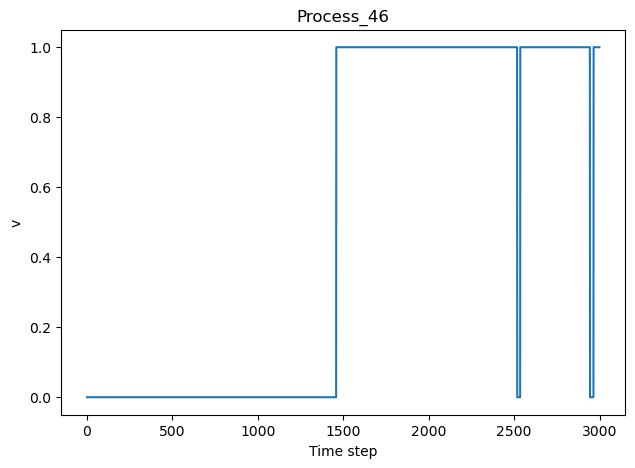

In [194]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

# Create a subplot for each monitor
fig = plt.figure(figsize=(16, 5))
ax0 = fig.add_subplot(121)

# Plot the recorded data
monitor_input.plot(ax0, spike_input.v)

# <b>Lava-nc Tutorial</b>

---
# Building a basic SNN with Lava

In [ ]:
%reset
import numpy as np
from lava.proc.lif.process import LIF
from lava.proc.dense.process import Dense

# LIF? use this to see params of LIF and some help  

Dense means all-all netowrk 

* lava works in terms of processes.
    * runs asynchronously 
    * parallel 
    * communicates via Channels
    * a process only defines the ports (i/o) and internal vars inital states not the behavior of the processes
    
![process.png](https://raw.githubusercontent.com/lava-nc/lava-docs/dev/walk-through-tutorial/_static/images/tutorial00/proc.png)

Below both LIF and Dense are diffrent processes


In [ ]:
# Create processes
lif1 = LIF(shape=(3, ),                         # Number and topological layout of units in the process
           vth=10.,                             # Membrane threshold
           dv=0.1,                              # Inverse membrane time-constant
           du=0.1,                              # Inverse synaptic time-constant
           bias_mant=(1.1, 1.2, 1.3),           # Bias added to the membrane voltage in every timestep
           name="lif1")

dense = Dense(weights=np.random.rand(2, 3),     # Initial value of the weights, chosen randomly
              name='dense')

lif2 = LIF(shape=(2, ),                         # Number and topological layout of units in the process
           vth=10.,                             # Membrane threshold
           dv=0.1,                              # Inverse membrane time-constant
           du=0.1,                              # Inverse synaptic time-constant
           bias_mant=0.,                        # Bias added to the membrane voltage in every timestep
           name='lif2')

LIF has one port in and one port out 

    * s_out => spike output
    * a_in => activation in

You can see i/o ports and internal valables, see below

In [ ]:
print("-- LIF")
print(f"lif ports out: {lif1.out_ports.member_names}")
print(f"lif in ports: {lif1.in_ports.member_names}")
print(f"internal lif vars: {lif1.vars.member_names}") # see inrernal var names
print(f"internal lif var state: {lif1.v}") # see current state of var
print("--------------------------------------")
print()
print("-- DENSE")
print(f"dense ports out: {dense.out_ports.member_names}")
print(f"dense in ports: {dense.in_ports.member_names}")
print(f"internal dense vars: {dense.vars.member_names}")
print(f"dense weights (init to random values): {dense.weights.get()}")
print("--------------------------------------")


ports can only connect if thier shapes match to see the shape use 

In [ ]:
print(f"LIF1 output dimension: {lif1.s_out.size}")
print(f"DENSE input dimension: {dense.s_in.size}")

So far we have just created processes, we need to connect them. This is done by useing the <code>connect</code> method

![process_comm.png](https://raw.githubusercontent.com/lava-nc/lava-docs/dev/walk-through-tutorial/_static/images/tutorial00/procs.png)

In [ ]:
# Connect the OutPort of lif1 to the InPort of dense
lif1.s_out.connect(dense.s_in)

# Connect the OutPort of dense to the InPort of lif2
dense.a_out.connect(lif2.a_in)

# NOTE: this python block should only be run once after you need to clear the varables to re-run it as processes can only be connected once 

The next step is to to run the network. This is done with the run function that takes two paramiters a <code>RunCondition</code> (how long) and a <code>RunConfig</code> (what hardware to run it on)

In [ ]:
from lava.magma.core.run_conditions import RunSteps, RunContinuous
num_steps = 100 # 100 discrete time units
run_condition = RunContinuous()
run_condition = RunSteps(num_steps=num_steps)

The <code>RunConfig</code> defines on which hardware backend the network is executed.

* Loihi1: <code>Loihi1HwCfg</code>
* Loihi2: <code>Loihi2HwCfg</code>
* Loihi1 simulated on CPU: <code>Loihi1SimCfg</code> 
* CPU: <code>floating_pt</code>

The compiler and runtime then automatically select the correct <code>ProcessModels</code> such that the <code>RunConfig</code> can be fulfilled.

In [ ]:
from lava.magma.core.run_configs import Loihi1SimCfg

run_cfg = Loihi1SimCfg(select_tag="floating_pt")

Running it is great! but we need to get data from it. To do that we need to setup monitors.

In [ ]:
from lava.proc.monitor.process import Monitor

monitor_lif1 = Monitor()
monitor_lif2 = Monitor()
monitor_lif1.probe(lif1.v, num_steps)
monitor_lif2.probe(lif2.v, num_steps)

In [ ]:
lif2.run(condition=run_condition, run_cfg=run_cfg) # run it again with monitors

Then we get data!

In [ ]:
data_lif1 = monitor_lif1.get_data()
data_lif2 = monitor_lif2.get_data()

Monitor also has some plot methods that we can make good use of.

In [ ]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

# Create a subplot for each monitor
fig = plt.figure(figsize=(16, 5))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

# Plot the recorded data
monitor_lif1.plot(ax0, lif1.v)
monitor_lif2.plot(ax1, lif2.v)

As a last step we can stop the runtime by calling the `stop` function. `Stop` will terminate the `Runtime` and all states will be lost.


In [ ]:
lif2.stop()

Now all we need is INPUT FROM A DATA SOURCE!

---

# Create a custom Process

In order to read in data, a custome process must be created. That is data I/O is mustly supported via custom process. This part goes over how to create custom processes. The orignal tutorial makes a random <code>SpikeGenerator</code> but here we will follow this, then attempt to read in the spike trains in <code>Prepocessing/data/spikeTrains</code>



In [ ]:
from lava.magma.core.process.process import AbstractProcess
from lava.magma.core.process.variable import Var
from lava.magma.core.process.ports.ports import OutPort

Each custom processes must inherit from the <code>AbstractProcess</code> class. In our class we define 

* Vars
* Input ports
* Output ports

For the random SpikeGenerator we will use a var to hold the probability of generating a spike and an output port. 

In [ ]:
class SpikeGenerator(AbstractProcess):
    """Spike generator process provides spikes to subsequent Processes.

    Parameters
    ----------
    shape: tuple
        defines the dimensionality of the generated spikes per timestep
    spike_prob: int
        spike probability in percent
    """
    def __init__(self, shape: tuple, spike_prob: int) -> None:        
        super().__init__()
        self.spike_prob = Var(shape=(1, ), init=spike_prob)
        self.s_out = OutPort(shape=shape)

Notice that <code>OutPort</code> and <code>Var</code> are classes imported from lava.

This class only defines the <code>Interface</code> of our custome process. To define the auctal logic we will need to add a <code>ProcessModels</code> to go with it. This will define the inner workings of our process. <i>ProcessModels can be found in the dedicated in-depth tutorials</i> ([here](https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial03_process_models.ipynb) and [here](https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial06_hierarchical_processes.ipynb)). Lava automatically selects the correct ProcessModel for each Process given the RunConfig.

![process_models.png](https://raw.githubusercontent.com/lava-nc/lava-docs/dev/walk-through-tutorial/_static/images/tutorial00/proc_models.png)

So in Summary our processes come in pairs of [Processes, ProcessModel] or [Interface, Logic]

Here we will define our ProcessModel in python to be run on a CPU. All <code>ProcessModels</code> defined to run on CPU are written in Python and inherit from the common class called <code>PyLoihiProcessModel</code>.

In [ ]:
from lava.magma.core.model.py.model import PyLoihiProcessModel # needed to define a CPU processes model
from lava.magma.core.resources import CPU
from lava.magma.core.decorator import implements, requires # decorators needed to define which computational resrouces are needed for our ProcessModel
from lava.magma.core.sync.protocols.loihi_protocol import LoihiProtocol
from lava.magma.core.model.py.type import LavaPyType # needed to define the internal vars of our model
from lava.magma.core.model.py.ports import PyOutPort # needed to degfine the output port

<b>Note: </b> It is important to mention that the `ProcessModel` needs to implement the exact same Vars and Ports of the parent process using the same class attribute names.

Our random SpikeGenertor model will follow the <code>LoihiProtocol</code> which defines phases for a neuron to run though. The main one is the <code>run_spk</code> and has 3 parts.

1. Input spikes are receved 
2. Internal vars are updated 
3. Output spikes are sent

There are other phases that can be added such as <i>learning phase</i> (run_lrn) where online learning can take place or <i>post management phase</i> (run_post_mgmt) in which memory content is updated. For our basic model we will only define the <code>run_spk</code> phase

We need access to the global simulation time, this can be done with the <code>self.time_step</code> member. This is used to index the `spike_data` and send out the corresponding spikes through the `OutPort`.

In [ ]:
@implements(proc=SpikeGenerator, protocol=LoihiProtocol) # tells lava this model pairs with the SpikeGenerator interface and is using the LoihiProtocol (a.k.a the phases talked about above)
@requires(CPU) # tells lava this uses the CPU 
class PySpikeGeneratorModel(PyLoihiProcessModel):
    """Spike Generator process model."""
    spike_prob: int = LavaPyType(int, int)
    s_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, float)

    def run_spk(self) -> None:
        # Generate random spike data
        spike_data = np.random.choice([0, 1], p=[1 - self.spike_prob/100, self.spike_prob/100], size=self.s_out.shape[0])
        
        # Send spikes
        self.s_out.send(spike_data)

<b>Note: </b> For the SpikeGenerator we only needed an OutPort which provides the <code>send</code> function to send data. For the <code>InPort</code> the corresponding function to receive data is called <code>recv</code>.

* OutPort: uses <code>send</code> method
* InPort: uses <code>recv</code> method

<b>Note: </b> spike probablity is shared between all instance of this model and the outport from lava is shared as well, while the spike sent out are per neuron.

Make a new network similar to the one before. 

In [ ]:
lif2?

In [ ]:
# Create processes
lif1 = LIF(shape=(3, ),                         # Number of units in this process
           vth=10.,                             # Membrane threshold
           dv=0.1,                              # Inverse membrane time-constant
           du=0.1,                              # Inverse synaptic time-constant
           bias_mant=0.,                        # Bias added to the membrane voltage in every timestep
           name="lif1")

dense = Dense(weights=np.random.rand(2, 3),     # Initial value of the weights, chosen randomly
              name='dense')

lif2 = LIF(shape=(2, ),                         # Number of units in this process
           vth=5.,                             # Membrane threshold
           dv=0.1,                              # Inverse membrane time-constant
           du=0.1,                              # Inverse synaptic time-constant
           bias_mant=0.,                        # Bias added to the membrane voltage in every timestep
           name='lif2')

# Connect the OutPort of lif1 to the InPort of dense
lif1.s_out.connect(dense.s_in)

# Connect the OutPort of dense to the InPort of lif2
dense.a_out.connect(lif2.a_in)

# Create Monitors to record membrane potentials
monitor_lif1 = Monitor()
monitor_lif2 = Monitor()
monitor_lif2_outputSpikes = Monitor()

# Probe membrane potentials from the two LIF populations
monitor_lif1.probe(lif1.v, num_steps)
monitor_lif2.probe(lif2.v, num_steps)
monitor_lif2_outputSpikes.probe(lif2.s_out, num_steps)

Now we add our new process random <code>SpikeGenerator</code> to the network. To connect it we go though a dense layer. 

In [ ]:
# Instantiate SpikeGenerator
spike_gen = SpikeGenerator(shape=(lif1.a_in.shape[0], ), spike_prob=10) 
 # neuron current = u[t] = u[t-1] * (1-du) + a_in so we want the output of SpikeGenerator to match the input of LIF a.k.a a_in.shape[0]
 # probablity as spike_prob/100 or as percent
 
 
# Instantiate Dense
dense_input = Dense(weights=np.eye(lif1.a_in.shape[0])) # one-to-one connectivity

# Connect spike_gen to dense_input
spike_gen.s_out.connect(dense_input.s_in) # SpikeGenerator.output => dense.input

# Connect dense_input to LIF1 population
dense_input.a_out.connect(lif1.a_in) # dense.output => LIF.input

#### <b>Now we run it!</b>

In [ ]:
lif2.run(condition=run_condition, run_cfg=run_cfg)

In [ ]:
# Create a subplot for each monitor
fig = plt.figure(figsize=(24, 10))
ax0 = fig.add_subplot(121)
# ax1 = fig.add_subplot(122)
ax2 = fig.add_subplot(122)

# Plot the recorded data
monitor_lif1.plot(ax0, lif1.v) # vth=10 for both LIF1 and LIF2
# monitor_lif2.plot(ax1, lif2.v)
monitor_lif2_outputSpikes.plot(ax2, lif2.s_out)

In [ ]:
lif2.stop()

---

# MNIST Digit Classification with Lava

We aim to make a SNN model composed of only dense and LIF layers. See the below figure 

<center><img src="https://raw.githubusercontent.com/lava-nc/lava-nc.github.io/main/_static/images/tutorial01/mnist_process_arch.png" alt="MNIST Process AA"
style="width: 800px;"/></center>

The 3 Processes shown above are:
 - *SpikeInput* Process - generates spikes via integrate and fire dynamics,
 using the image input
 - *ImageClassifier* Process - encapsulates feed-forward architecture of
 Dense connectivity and LIF neurons
 - *Output* Process - accumulates output spikes from the feed-forward process
and infers the class label

> **Important Note**:
>
> The classifier is a simple feed-forward model using pre-trained network 
> parameters (weights and biases). It illustrates how to build, compile and 
> run a functional model in Lava. Please refer to 
> [Lava-DL](https://github.com/lava-nc/lava-dl) to understand how to train 
> deep networks with Lava.

##### Imports

In [ ]:
%reset
# general 
import numpy as np
import os
import numpy as np
import typing as ty

# ploting
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

# snn stuff
from lava.proc.lif.process import LIF
from lava.proc.dense.process import Dense
from lava.proc.monitor.process import Monitor
from lava.magma.core.run_conditions import RunSteps, RunContinuous
from lava.magma.core.run_configs import Loihi1SimCfg

# Import Process level primitives
from lava.magma.core.process.process import AbstractProcess
from lava.magma.core.process.variable import Var
from lava.magma.core.process.ports.ports import InPort, OutPort

# Import parent classes for ProcessModels
from lava.magma.core.model.sub.model import AbstractSubProcessModel
from lava.magma.core.model.py.model import PyLoihiProcessModel

# Import ProcessModel ports, data-types
from lava.magma.core.model.py.ports import PyInPort, PyOutPort
from lava.magma.core.model.py.type import LavaPyType

# Import execution protocol and hardware resources
from lava.magma.core.sync.protocols.loihi_protocol import LoihiProtocol
from lava.magma.core.resources import CPU

# Import decorators
from lava.magma.core.decorator import implements, requires

# Import MNIST dataset
from lava.utils.dataloader.mnist import MnistDataset
np.set_printoptions(linewidth=np.inf)

Okay the first processes os the spike input. We define the process then process model.

In [ ]:
# Process deinftion
class SpikeInput(AbstractProcess):
    """Reads image data from the MNIST dataset and converts it to spikes.
    The resulting spike rate is proportional to the pixel value."""

    def __init__(self,
                 vth: int,
                 num_images: ty.Optional[int] = 25,
                 num_steps_per_image: ty.Optional[int] = 128):
        super().__init__()
        shape = (784,)
        self.spikes_out = OutPort(shape=shape)  # Input spikes to the classifier
        self.label_out = OutPort(shape=(1,))  # Ground truth labels to OutputProc
        self.num_images = Var(shape=(1,), init=num_images)
        self.num_steps_per_image = Var(shape=(1,), init=num_steps_per_image)
        self.input_img = Var(shape=shape)
        self.ground_truth_label = Var(shape=(1,))
        self.v = Var(shape=shape, init=0)
        self.vth = Var(shape=(1,), init=vth)

#### \_\_init\_\_ 
In out process model we define a couple peaces to convert the images to spike trains. First in \_\_init\_\_ we setup out data loader <code>mnist_dataset</code> we initializ an image ID, starting from 0

#### post_guard
For our post_guard we want to check if we are done reading an image. Sense these are still images we need to convert them to time series. num_steps_per_image basicly controls how long each image should "play", that is how long our spike trains are. The <code>post_guard</code> control when we are done with an image, that is when it's time series has ended.

#### run_post_mgmt


In [ ]:
@implements(proc=SpikeInput, protocol=LoihiProtocol)
@requires(CPU)
class PySpikeInputModel(PyLoihiProcessModel):
    num_images: int = LavaPyType(int, int, precision=32)
    spikes_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, bool, precision=1)
    label_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, np.int32,
                                      precision=32)
    num_steps_per_image: int = LavaPyType(int, int, precision=32)
    input_img: np.ndarray = LavaPyType(np.ndarray, int, precision=32)
    ground_truth_label: int = LavaPyType(int, int, precision=32)
    v: np.ndarray = LavaPyType(np.ndarray, int, precision=32)
    vth: int = LavaPyType(int, int, precision=32)
    
    def __init__(self, proc_params):
        super().__init__(proc_params=proc_params)
        self.mnist_dataset = MnistDataset()
        self.curr_img_id = 0

    def post_guard(self):
        """Guard function for PostManagement phase.
        """
        if self.time_step % self.num_steps_per_image == 1:
            return True
        return False

    def run_post_mgmt(self):
        """Post-Management phase: executed only when guard function above 
        returns True.
        """
        img = self.mnist_dataset.images[self.curr_img_id]
        self.ground_truth_label = self.mnist_dataset.labels[self.curr_img_id]
        self.input_img = img.astype(np.int32) - 127
        self.v = np.zeros(self.v.shape)
        self.label_out.send(np.array([self.ground_truth_label]))
        self.curr_img_id += 1

    def run_spk(self):
        """Spiking phase: executed unconditionally at every time-step
        """
        self.v[:] = self.v + self.input_img
        s_out = self.v > self.vth
        self.v[s_out] = 0  # reset voltage to 0 after a spike
        self.spikes_out.send(s_out)

Now lets see if we can just see the input working

In [ ]:
num_images = 25
num_steps_per_image = 128

# Create Process instances
spike_input = SpikeInput(vth=1,
                         num_images=num_images,
                         num_steps_per_image=num_steps_per_image)

# Create Monitors to record membrane potentials
monitor_SpikeInput = Monitor()


# Probe membrane potentials from the two LIF populations
monitor_SpikeInput.probe(spike_input.spikes_out, num_steps_per_image)

mnist_clf.run(
    condition=RunSteps(num_steps=num_steps_per_image),
    run_cfg=Loihi1SimCfg(select_sub_proc_model=True,
                        select_tag='fixed_pt'))